In [4]:
from urllib import urlencode
import requests
import json
import re
import pandas as pd
ipos = pd.read_csv('ipos.csv')
aqns = pd.read_csv('acquisitions.csv')
rds = pd.read_excel('invrounds.xlsx')

names = list(rds['company_name'])
multnames = set()
for x in names:
    if names.count(x) > 1:
        multnames.add(x)

def tsvc_cat(s):
    if s in ('Computer', 'Consumer Electronics', 'DIY', 'Electronics', 'Hardware', 
             'Home Automation', 'Internet of Things', 'Lighting', 'Mobile Devices', 'NFC',
             'RFID', 'Sensor', 'Wireless'):
        return 'Microelectronics'
    elif s in ('Analytics', 'Artificial Intelligence', 'Autonomous Vehicles', 'Big Data', 
               'Biometrics', 'Cloud Computing', 'Cloud Data Services', 'Cloud Infrastructure', 
               'Cloud Management', 'Cloud Security', 'Computer Vision', 'Data Center', 
               'Data Integration', 'Data Mining', 'Data Visualization', 'Database', 'EdTech',
               'Enterprise Software', 'Facial Recognition', 'Geospatial', 'IaaS', 'Information Services',
               'Information Technology', 'Location Based Services', 'Logistics',
               'Machine Learning', 'Mapping Services', 'Natural Language Processing', 
               'Navigation', 'Predictive Analytics', 'Private Cloud', 'Public Transportation', 
               'Robotics', 'SaaS', 'Search Engine', 'Semantic Search', 'Semantic Web', 
               'Text Analytics'):
        return 'Data Science'
    elif s in ('3D Printing', 'Biofuel', 'Biotechnology', 'Chemical', 'Clean Energy', 
               'CleanTech', 'Craft Beer', 'Dietary Supplements', 'Fashion', 'Food and Beverage',
               'Furniture', 'Manufacturing', 'Nanotechnology', 'Oil and Gas', 'Organic'
               'Organic Food', 'Pharmaceutical', 'Renewable Energy', 'Textiles'):
        return 'New Materials'
    else:
        return 'Other'
    
def tsvc_cat_list(x):
    ans = set(['All'])
    for y in str(x['company_category_list']).split('|'):
        ans.add(tsvc_cat(y))
    if (ans & set(['Microelectronics', 'Data Science', 'New Materials'])):
        ans.add('All TSVC')
    if x['country_code'] != 'USA':
        for y in ans.copy():
            ans.add(y + ' non-USA')
    return list(ans)
        
        
invs = {}
for x in multnames:
    invs[x] = []
rounds = rds.to_dict('records')
for x in rounds:
    name = x['company_name'] 
    if name in multnames:
        invs[name].append({'country': x['country_code'], 'region': x['region'], 
                           'category': [i.strip() for i in str(x['company_category_list']).split('|')] + ['All'],  
                           'announced': x['announced_on'], 'type': x['funding_round_type'], 
                           'round' : x['funding_round_code'], 'sum' : x['raised_amount_usd'], 
                           'pmval': x['post_money_valuation_usd']})

categs = set('All')
for x in invs.values():
    for y in x:
        for z in y['category']:
            categs.add(z)
cats = {}
for x in categs:
    cats[x] = []

#cats = {'Microelectronics':[], 'Data Science':[], 'New Materials':[], 'All TSVC':[], 'Other':[],
#        'Microelectronics non-USA':[], 'Data Science non-USA':[], 'New Materials non-USA':[],
#        'All TSVC non-USA':[], 'Other non-USA':[], 'All':[], 'All non-USA':[]}
    
def calculate_returns(name, lst):
    from datetime import datetime
    ans = []
    for i in xrange(len(lst)-1):
        y = lst[i]
        x = lst[i+1]
        ret = {}
        try:
            date1 = datetime.strptime(x['announced'], '%Y-%m-%d').date()
            date2 = datetime.strptime(y['announced'], '%Y-%m-%d').date()
        except TypeError:
            pass 
        if date1 > date2:
            date1, date2 = date2, date1
            x, y = y, x
        ret['name'] = name
        ret['region'] = x['region']
                
        if (x['type'] == 'angel') or (x['type'] == 'seed'):
            stage1 = 'S'
        elif (x['round'] in ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']) and (x['type'] == 'venture'):
            stage1 = x['round']
        elif (x['type'] == 'IPO'):
            stage1 = 'I'
        elif x['type'] == 'MNA':
            stage1 = 'M'
        else:
            stage1 = 'O'
                    
        if (y['type'] == 'angel') or (y['type'] == 'seed'):
            stage2 = 'S'
        elif (y['round'] in ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']) and (y['type'] == 'venture'):
            stage2 = y['round']
        elif (y['type'] == 'IPO'):
            stage2 = 'I'
        elif y['type'] == 'MNA':
            stage2 = 'M'
        else:
            stage2 = 'O'
                    
        ret['stage'] = stage1 + stage2
        ret['mult'] = (y['pmval'] - y['sum']) / x['pmval']
        
        
        
        ret['inv_date'] = date1
        ret['delta'] = (date2 - date1).days
        try:
            ret['irr'] = ret['mult'] ** (365.25 * 1.25 / ret['delta'])
        except ZeroDivisionError:
            ret['irr'] = 1.
            print 'division by zero primary ' + str(ret)
        ans.append(ret)
    
    for i in xrange(len(lst)):
        for x in ans:
            for y in ans:
                if (y['inv_date'] - x['inv_date']).days == x['delta']:
                    needed = True
                    for z in ans:
                        needed = needed and (not ((z['inv_date'] == x['inv_date']) and 
                                                  (z['delta'] == x['delta'] + y['delta'])))
                    if needed:
                        ret = x.copy()
                        ret['delta'] = x['delta'] + y['delta']
                        ret['stage'] = x['stage'][0] + y['stage'][1]
                        ret['mult'] = x['mult'] * y['mult']
                        try:
                            ret['irr'] = ret['mult'] ** (365.25 * 1.25 / ret['delta'])
                        except ZeroDivisionError:
                            ret['irr'] = 1.
                            print 'division by zero secondary ' + str(ret)
                        ans.append(ret)                     
            
    
    nans = []
    for x in ans:
        for y in lst[0]['category']:
            nret = x.copy()
            nret['cat'] = y
            nans.append(nret)
    return nans

In [21]:
uber = invs['Uber']

print len(invs)

print uber
print calculate_returns('Uber', uber)



696
[{'category': ['Mobile Apps', 'Public Transportation', 'Transportation', 'All'], 'sum': 3500000000.0, 'country': u'USA', 'region': u'SF Bay Area', 'type': u'venture', 'round': u'G', 'announced': u'2016-06-01', 'pmval': 62500000000.0}, {'category': ['Mobile Apps', 'Public Transportation', 'Transportation', 'All'], 'sum': 1000000000.0, 'country': u'USA', 'region': u'SF Bay Area', 'type': u'venture', 'round': u'F', 'announced': u'2015-07-31', 'pmval': 51000000000.0}, {'category': ['Mobile Apps', 'Public Transportation', 'Transportation', 'All'], 'sum': 1000000000.0, 'country': u'USA', 'region': u'SF Bay Area', 'type': u'venture', 'round': u'E', 'announced': u'2015-02-18', 'pmval': 41000000000.0}, {'category': ['Mobile Apps', 'Public Transportation', 'Transportation', 'All'], 'sum': 1200000000.0, 'country': u'USA', 'region': u'SF Bay Area', 'type': u'venture', 'round': u'E', 'announced': u'2014-12-04', 'pmval': 41200000000.0}, {'category': ['Mobile Apps', 'Public Transportation', 'Tran

In [23]:
from copy import deepcopy
dat = {'S' : {'A':[], 'B':[], 'C':[], 'D':[], 'E':[], 'F':[], 'G':[], 'H':[]},
       'A' : {'B':[], 'C':[], 'D':[], 'E':[], 'F':[], 'G':[], 'H':[]},
       'B' : {'C':[], 'D':[], 'E':[], 'F':[], 'G':[], 'H':[]},
       'C' : {'D':[], 'E':[], 'F':[], 'G':[], 'H':[]},
       'D' : {'E':[], 'F':[], 'G':[], 'H':[]},
       'E' : {'F':[], 'G':[], 'H':[]},
       'F' : {'G':[], 'H':[]},
       'G' : {'H':[]}}


for x in invs:
    cr = calculate_returns(x, invs[x])
    for y in cr:
        try:
            dat[y['stage'][0]][y['stage'][1]].append(y)
            print y['stage']
        except KeyError:
            pass
    
        

SA
SA
SA
SA
SA
CD
CD
CD
CD
CD
CD
CD
CD
SA
SA
SA
SA
SA
SA
SA
SA
SA
SA
SA
BC
BC
BC
BC
BC
EF
EF
EF
EF
EF
EF
DE
DE
DE
DE
DE
DE
DF
DF
DF
DF
DF
DF
AB
AB
AB
AB
SA
SA
SA
SA
SB
SB
SB
SB
AB
AB
AB
AB
BC
BC
BC
BC
FG
FG
FG
FG
FG
CF
CF
CF
CF
CF
FG
FG
FG
FG
FG
FG
FG
FG
FG
FG
CG
CG
CG
CG
CG
CG
CG
CG
CG
CG
CG
CG
CG
CG
CG
AB
AB
AB
AB
AB
SA
SA
SA
SA
SA
SA
SA
CF
CF
CF
CF
CD
CD
CD
CD
CD
CD
CD
division by zero primary {'name': u'Paktor', 'region': u'Singapore', 'inv_date': datetime.date(2014, 11, 17), 'delta': 0, 'irr': 1.0, 'mult': 0.7272727272727273, 'stage': u'AA'}
CD
CD
CD
CD
BC
BC
BC
BC
BD
BD
BD
BD
CD
CD
BC
BC
AB
AB
SA
SA
BD
BD
AC
AC
AD
AD
SB
SB
SC
SC
SD
SD
DE
DE
DE
DE
DE
BC
BC
BC
BC
AB
AB
AB
AB
AB
SA
SA
SA
SA
SA
EF
EF
EF
EF
EF
EF
EF
CE
CE
CE
CE
CE
CE
CE
CF
CF
CF
CF
CF
CF
CF
AB
AB
AB
AB
division by zero primary {'name': u'GymForLess', 'region': u'Barcelona', 'inv_date': datetime.date(2016, 9, 1), 'delta': 0, 'irr': 1.0, 'mult': 0.9259259259259259, 'stage': 'SS'}
DE
DE
DE
EF
EF
EF
EF
AB
AB
AB
AB
AB
SA
S

In [24]:
'''from pprint import pprint
f = open("crunchbaseout.txt","w")
pprint(dat, stream=f)'''

print dat



{'A': {'C': [{'inv_date': datetime.date(2012, 1, 10), 'name': u'KuponGid', 'delta': 388, 'region': u'Moscow', 'cat': 'Coupons', 'irr': 1.2277250865936074, 'mult': 1.1904761904761905, 'stage': u'AC'}, {'inv_date': datetime.date(2012, 1, 10), 'name': u'KuponGid', 'delta': 388, 'region': u'Moscow', 'cat': 'All', 'irr': 1.2277250865936074, 'mult': 1.1904761904761905, 'stage': u'AC'}, {'inv_date': datetime.date(2011, 2, 14), 'name': u'Uber', 'delta': 921, 'region': u'SF Bay Area', 'cat': 'Mobile Apps', 'irr': 7.085496453621161, 'mult': 51.92878338278931, 'stage': u'AC'}, {'inv_date': datetime.date(2011, 2, 14), 'name': u'Uber', 'delta': 921, 'region': u'SF Bay Area', 'cat': 'Public Transportation', 'irr': 7.085496453621161, 'mult': 51.92878338278931, 'stage': u'AC'}, {'inv_date': datetime.date(2011, 2, 14), 'name': u'Uber', 'delta': 921, 'region': u'SF Bay Area', 'cat': 'Transportation', 'irr': 7.085496453621161, 'mult': 51.92878338278931, 'stage': u'AC'}, {'inv_date': datetime.date(2011, 2

In [26]:
from numpy import std
import numpy as np
from matplotlib import pylab as plt
import scipy.stats as sts
from copy import deepcopy
%matplotlib inline

dat2 = {'S' : {'A':[], 'B':[], 'C':[], 'D':[], 'E':[], 'F':[], 'G':[], 'H':[]},
        'A' : {'A':[], 'B':[], 'C':[], 'D':[], 'E':[], 'F':[], 'G':[], 'H':[]},
        'B' : {'A':[], 'B':[], 'C':[], 'D':[], 'E':[], 'F':[], 'G':[], 'H':[]},
        'C' : {'A':[], 'B':[], 'C':[], 'D':[], 'E':[], 'F':[], 'G':[], 'H':[]},
        'D' : {'A':[], 'B':[], 'C':[], 'D':[], 'E':[], 'F':[], 'G':[], 'H':[]},
        'E' : {'A':[], 'B':[], 'C':[], 'D':[], 'E':[], 'F':[], 'G':[], 'H':[]},
        'F' : {'A':[], 'B':[], 'C':[], 'D':[], 'E':[], 'F':[], 'G':[], 'H':[]},
        'G' : {'A':[], 'B':[], 'C':[], 'D':[], 'E':[], 'F':[], 'G':[], 'H':[]}}
dat3 = deepcopy(dat2)
dat4 = deepcopy(dat2)
dat5 = deepcopy(dat2)

def gmean(l):
    product = 1.
    for i in l:
        product *= i
    return product ** (1. / len(l))

def gstd(l):
    import numpy as np
    return np.exp(np.std([np.log(x) for x in l])) 

plotnum = iter(xrange(1, 200))
#fig = plt.figure()

from matplotlib.backends.backend_pdf import PdfPages
#pp = PdfPages('crunchbaserrs.pdf')
ymax = 100

for stage in dat:
    for cat in dat[stage]:
        sample = [x['mult'] for x in dat[stage][cat] ]#if x['irr'] < ymax]
        if len(sample) < 2:
            dat2[stage][cat] = None
            dat3[stage][cat] = None
            dat4[stage][cat] = None
            dat5[stage][cat] = None
            continue            
        else:
            gm = gmean(sample)
            gs = gstd(sample)
            dat2[stage][cat] = gm
            dat3[stage][cat] = gs
            dat4[stage][cat] = len(sample)
            dat5[stage][cat] = str(sample)
            #lognorm = sts.lognorm(np.log(gs), loc=np.log(gm))
            #x = np.linspace(0, ymax, 20*ymax)            
           # pd.DataFrame(sample, columns = ['KDE']).plot(kind='density', lw=2)
          #  plt.hist(sample, bins = np.arange(0, 10, 1./3), label='Histogram', normed=True)
         #   plt.plot(x, lognorm.pdf(x), label = 'lognorm fit', c = 'purple', lw=2)
        #    plt.axvspan(gm / gs ** 0.5, gm * gs ** 0.5, alpha=0.4, color='orange', label = '${\mu}*{\div}{\sqrt {\sigma}}$')
       #     plt.legend()
      #      plt.xlim([0, ymax])
     #       plt.ylim([0, 1])
    #        plt.title(stage + ', ' + cat + '\n ' + str(len(sample)) + ' datapoints, ' +  
   #               'gmean=' + str(round(gm, 1)) + ', gstd=' + str(round(gs, 1)) + 'x')
  #          plt.xlabel('Hypothetical 15-month returns (1+r)')
 #           pp.savefig()
#            plt.close()
            #plt.show()
#pp.close()

dat2pd = pd.DataFrame.from_dict(dat2)
dat3pd = pd.DataFrame.from_dict(dat3)
dat4pd = pd.DataFrame.from_dict(dat4)
dat5pd = pd.DataFrame.from_dict(dat5)
writer = pd.ExcelWriter('crunchbasefunnelx.xlsx')
dat2pd.to_excel(writer,'GeoMeans')
dat3pd.to_excel(writer,'GeoStdDeviations')
dat4pd.to_excel(writer,'Size')
dat5pd.to_excel(writer,'Data')
writer.save()



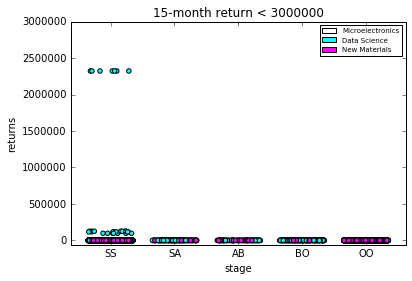

In [84]:
from matplotlib import pyplot as plt
%matplotlib inline
def companies_in_cat(c, invs):
    ans = []
    for x in invs:
        if c in invs[x][0]['category']:
            ans.append(x)
    return ans

myx = ['SS', 'SA', 'AB', 'BO', 'OO']
pp = PdfPages('crunchbasescatters.pdf')

def jitter(arr):
    return arr + np.random.uniform(low=-0.35, high=0.35, size=len(arr))

def col(cat):
    return 'aqua' if cat == 'Data Science' else 'white' if cat == 'Microelectronics' else 'magenta'

x = []
y = []
collst = []
l = []


for stage in xrange(5):
    for cat in cats:
        for point in dat[myx[stage]][cat]:
            if True:
                x.append(stage)
                y.append(point['irr'])
                collst.append(col(cat))
                l.append(cat)
                
import matplotlib.patches as mpatches

classes = ['Microelectronics', 'Data Science', 'New Materials']
class_colours = ['white', 'aqua', 'magenta']
recs = []
for i in range(0,len(class_colours)):
    recs.append(mpatches.Rectangle((0,0),1,1,fc=class_colours[i]))
plt.legend(recs,classes,loc=4)

def my_formatter_fun(x, p):
    return str(round(x, 1)) + 'x'


for ylim in [6, 20, 100, 1000, 10000, 300000, 3*10**6]:
    plt.scatter(jitter(np.array(x)), y, color=collst, edgecolors='black')
    plt.xticks(range(5), myx)
    plt.title('15-month return < ' + str(ylim))
    plt.ylim((-1-ylim/50, ylim))
    plt.xlabel('stage')
    plt.ylabel('returns')
    plt.legend(recs,classes, prop={'size':7})
    pp.savefig()
pp.close()



In [5]:
country_stats = {}
for x in invs:
    try:
        country_stats[invs[x][0]['country']] += 1
    except KeyError:
        country_stats[invs[x][0]['country']] = 1
        
print sorted(country_stats, key=country_stats.get)




[u'NGA', u'TWN', u'UKR', u'CYP', u'ROM', u'PRT', u'POL', u'HKG', u'LBN', u'EST', u'SVK', u'HRV', u'BLR', u'TUR', u'KOR', u'CHE', u'CHL', u'NOR', u'THA', u'ZAF', u'MEX', u'EGY', u'LUX', u'AUT', u'NZL', u'DNK', u'JPN', u'ARE', u'ARG', u'ISR', u'PER', u'SWE', u'BEL', u'FRA', u'IRL', u'BRA', u'ITA', u'RUS', u'FIN', u'AUS', u'NLD', u'SGP', u'DEU', u'BGR', u'CHN', u'IND', u'ESP', u'CAN', nan, u'GBR', u'USA']


In [15]:
def companies_in_cat(c, invs):
    ans = []
    for x in invs:
        if c in invs[x][0]['category']:
            ans.append(x)
    return ans
print companies_in_cat('Training', invs)

    

[u'Salted Earth', u'Nextwin Srl', u'CooCoo', u'Runteq']


In [28]:
ipos = pd.read_csv('ipos.csv')
links = []
dates = []
vals = []


for y in ipos['uuid']:
    #print y
    x = get_ipo(y)
    links.append(x[0])
    dates.append(x[1])
    vals.append(x[2])
    
    
ipos['permalink'] = links
ipos['date'] = dates
ipos['valuation'] = vals

ipos.to_csv('ipos.csv')






,uuid,updated_at,permalink,date,valuation
0,00092ea5-e2c5-4eb6-66b1-3c11c642e0ee,2016-06-14 05:32:03.691715,xiwang-foodstuffs,2000-09-22,NaN
1,000b4aa3-2a94-7e4f-fe38-9210f529ecdf,2016-09-07 17:29:09.866094,husky-energy,2000-09-08,NaN
2,0017815c-a214-fb3f-3d3b-203c3c894e87,2015-07-16 23:24:21,plaza-bank,2006-09-01,NaN
3,001be5bb-9337-232a-a823-2e22a3c6920c,2015-12-24 08:12:53.424479,korn-ferry-international,1999-02-11,5.007877e+08
4,001c65fb-58fe-08a4-4660-dac89bf0b024,2015-07-16 23:12:06,american-axle-manufacturing,1999-02-05,NaN
5,001e9b36-8beb-7706-ca13-ae7c329d578a,2015-07-16 23:31:09,epr-properties,1997-11-28,NaN
6,00269633-955f-2ef6-52d2-1f99f3b18919,2015-07-16 23:50:04,aurico-gold,2011-01-14,NaN
7,002a2891-abaf-5734-2c90-a2693f332acc,2015-07-16 23:55:59,hess-corporation,1978-01-13,NaN
8,00458df7-9a54-203c-531d-80bc3bc00fb7,2015-07-16 23:09:00,golden-minerals,1997-11-25,NaN
9,00479227-931d-54f9-183b-af267a151849,2015-07-16 23:59:16,cms-energy-corporation,1978-01-13,NaN


In [29]:
ipos.to_csv('ipos.csv')

In [2]:
print invs

{u'Clicko': [{'category': ['Mobile', 'All'], 'sum': 66086.0, 'country': u'BGR', 'region': u'Sofia', 'type': u'seed', 'round': nan, 'announced': u'2013-09-01', 'pmval': 732961.0}, {'category': ['Mobile', 'All'], 'sum': 32842.0, 'country': u'BGR', 'region': u'Sofia', 'type': u'seed', 'round': nan, 'announced': u'2013-05-01', 'pmval': 443367.0}], u'ClassWallet': [{'category': ['EdTech', 'Education', 'Finance', 'Software', 'All'], 'sum': 1500000.0, 'country': u'USA', 'region': u'Miami', 'type': u'venture', 'round': u'A', 'announced': u'2016-04-16', 'pmval': 8500000.0}, {'category': ['EdTech', 'Education', 'Finance', 'Software', 'All'], 'sum': 635000.0, 'country': u'USA', 'region': u'Miami', 'type': u'angel', 'round': nan, 'announced': u'2014-05-15', 'pmval': 3135000.0}], u'Alibaba': [{'category': ['E-Commerce', 'Marketplace', 'Shopping', 'All'], 'sum': 2000000000.0, 'country': u'CHN', 'region': u'Hangzhou', 'type': u'private_equity', 'round': nan, 'announced': u'2012-09-01', 'pmval': 40000

In [11]:
catin = {'Advertising':[], 'All':[], 'Biotechnology':[], 'Cloud Computing':[], 'Consumer Electronics':[],
        'Crowdfunding':[], 'E-Commerce':[], 'Education':[], 'Enterprise Software':[], 'Fashion':[],
        'Finance':[], 'Fitness':[], 'Hardware':[], 'Health Care':[], 'Internet of Things':[],
        'Manufacturing':[], 'Messaging':[], 'Mobile Payments':[], 'Music':[], 'Real Estate':[],
        'Retail':[], 'Search Engine':[], 'Social Media':[], 'Transportation':[], 'Travel':[], 'Video':[]}

def gmean(l):
    product = 1.
    for i in l:
        product *= i
    return product ** (1. / len(l))

for x in invs:
    cr = calculate_returns(x, invs[x])
    ret = gmean([i['irr'] for i in cr])
    for y in invs[x][0]['category']:
        if y in catin:
            catin[y].append({'name':x, 'invs':len(cr) / len(invs[x][0]['category']), 'return':ret})

print ''
print ''
print catin
    

division by zero primary {'name': u'Paktor', 'region': u'Singapore', 'inv_date': datetime.date(2014, 11, 17), 'delta': 0, 'irr': 1.0, 'mult': 0.7272727272727273, 'stage': u'AA'}
division by zero primary {'name': u'GymForLess', 'region': u'Barcelona', 'inv_date': datetime.date(2016, 9, 1), 'delta': 0, 'irr': 1.0, 'mult': 0.9259259259259259, 'stage': 'SS'}
division by zero primary {'name': u'OvuSense (Fertility Focus)', 'region': u'Warwick', 'inv_date': datetime.date(2015, 7, 1), 'delta': 0, 'irr': 1.0, 'mult': 0.837664338537387, 'stage': 'SS'}
division by zero primary {'name': u'Qranio', 'region': u'BRA - Other', 'inv_date': datetime.date(2013, 1, 5), 'delta': 0, 'irr': 1.0, 'mult': 0.13333333333333333, 'stage': 'SS'}
division by zero primary {'name': u'Agora.io', 'region': u'SF Bay Area', 'inv_date': datetime.date(2015, 9, 15), 'delta': 0, 'irr': 1.0, 'mult': 1.0, 'stage': u'BB'}
division by zero primary {'name': u'SpaceConnect', 'region': u'Sydney', 'inv_date': datetime.date(2015, 4, 

In [25]:
topcatin = {}
for x in catin:
    toplist = sorted([i for i in catin[x] if i['invs'] > 2], key = lambda k: k['return'], reverse = True)
    if len(toplist) > 4:
        topcatin[x] = toplist[:5]
    else:
        topcatin[x] = toplist

import pandas as pd
tci = {'Name':[], 'Category':[], 'Rounds':[], 'Return':[]}
for category in topcatin:
    for company in topcatin[category]:
        tci['Name'].append(company['name'])
        tci['Category'].append(category)
        tci['Rounds'].append(round((1 + (1 + 8 * company['invs']) ** 0.5) / 2.))
        tci['Return'].append(company['return'])
tci = pd.DataFrame(tci)
tci
tci.to_excel('topcatin.xlsx')
    